<a href="https://colab.research.google.com/github/anilbhatt1/EVA4P1_S15B_Depth_FG_Detection/blob/master/EVA4P1_S15_Comb_FG_Depth_Prediction_LossFn_Modified_for_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! nvidia-smi

Fri Jun  5 13:53:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import warnings
warnings.filterwarnings('ignore')
import zipfile
from zipfile import ZipFile
from pathlib import Path
from time import time
from datetime import datetime 
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from PIL import Image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import cv2
import pkgutil
import importlib
import os
%matplotlib inline
%config IPCompleter.greedy=True
%reload_ext autoreload
import seaborn as sns
import io
import skimage
from skimage.transform import resize
from itertools import groupby
from tqdm.auto import tqdm
import gc
sns.set()

#import albumentations
#print(albumentations.__version__) # check version

# This is to install and use albumentations latest package v0.4.5
#album_version_needed = "0.4.5"
#if albumentations.__version__ != album_version_needed:
#  !pip install albumentations==0.4.5   # 0.4.5 is the latest albumentation version
print('Pytorch version:', torch.__version__)

!pip install kornia
from kornia.losses import SSIM
from kornia.losses import DiceLoss

Pytorch version: 1.5.0+cu101


### Unzip FG_BG, Mask, Depth and corresponding BG images from gdrive

In [0]:
t1 = time()
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_400K.zip"
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Mask_400K.zip"
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Depth_400K.zip"
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/BG_and_Its_Flip.zip"
t2 = time()
print(f'FG_BG, Mask & Depth Copy took {(t2-t1)/60:.5f} minutes')

FG_BG, Mask & Depth Copy took 5.64660 minutes


### Copying Log file that contains FG_BG file names, their path in gdrive & corresponding BG file name from which they were made 

In [0]:
if os.path.exists('/content/FG_BG_Filename_withflip_Logs.txt'):
    print('Log file exists')    
else:  
    !cp '/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Filename_withflip_Logs.txt' '/content/'
    print('Copied Log File')

Copied Log File


### Copying SRC libraries from Github to Colab.

In [0]:
# Copying the code from github to colab
os.chdir('/content/')
!git clone https://github.com/anilbhatt1/EVA4P1_S15B_Depth_FG_Detection

Cloning into 'EVA4P1_S15B_Depth_FG_Detection'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 489 (delta 33), reused 0 (delta 0), pack-reused 441
Receiving objects: 100% (489/489), 14.91 MiB | 7.38 MiB/s, done.
Resolving deltas: 100% (250/250), done.


In [0]:
%cd '/content/EVA4P1_S15B_Depth_FG_Detection/src/losses'
! ls

/content/EVA4P1_S15B_Depth_FG_Detection/src/losses
Test1.py  Test3.py  Train1.py  Train3.py
Test2.py  Test.py   Train2.py  Train.py


### Importing modules from Colab data folder to Colab session 

In [0]:
os.chdir('/content/EVA4P1_S15B_Depth_FG_Detection/')
import src
from src.dataset import datatransforms as dtf
from src.dataset import makedata as md
from src.dataset import make1data as md1
from src.dataset import Alb_data_transforms as Alb
from src.models  import S15_FGDepth_models as ntwk
from src.losses  import Train as Train
from src.losses  import Test  as Test
from src.losses  import Train1 as Train1
from src.losses  import Test1  as Test1
from src.losses  import Train2 as Train2
from src.losses  import Test2  as Test2
from src.losses  import Train3 as Train3
from src.losses  import Test3  as Test3
from src.utils   import Freeze_Layers as Freeze

### Creating a list - content_list for FG_BG log file. This content_list will be used to create dataloader to pick-up input images randomly for both training and testing

In [0]:
log_fg_bg = open('/content/FG_BG_Filename_withflip_Logs.txt',"r")
content_list = log_fg_bg.readlines()
print('No: of records in log_fg_bg:',len(content_list))
print(content_list[0])
log_fg_bg.close()

data_root = Path('/content')
f1, f2, f3, f4 = data_root/'FG_BG_400K', data_root/'BG_and_Its_Flip', data_root/'FG_BG_Mask_400K',  \
                 data_root/'FG_BG_Depth_0_400K'

No: of records in log_fg_bg: 400000
Img_fg_bg_1.jpg,Img21.jpg,Image41.png,(192, 192, 108, 156, 51, 3, 159, 3, 51, 159, 159, 159)



In [0]:
bs_small  = 96
bs_medium = 96
bs_large  = 16
bs_test   = 96
bs_display= 8
rows = 5
img_save, model_save = 1500, 500
t0k, t10k, t20k, t80k, t160k, t220k, t260k, t280k, t360k, t390k, t400k  = 0, 10000,  20000, 80000, 160000, 220000,\
                                                                             260000, 280000, 360000,\
                                                                                     390000, 400000

### Creating tranforms. For test data, GT mask & GT depth only 'To Tensor' & 'Resize' is used.

In [0]:
import albumentations as A
lst = [(64,64),(96,96),(192,192)]
fg_bg_mean, fg_bg_stdev                    = [0.56670278, 0.49779153, 0.43632878], [0.25049532, 0.2468085, 0.25520498]
mask_mean,  mask_stdev                     = [0.20249742], [0.39961225]
depth_mean, depth_stdev                    = [0.32939295], [0.24930712]
bg_mean, bg_stdev                          = [0.58245822, 0.51269352, 0.43691653], [0.24252189, 0.24318804, 0.25401604]
#fg_bg_mean, fg_bg_stdev                    = [144.5, 126.9, 111.26], [63.88, 62.94, 65.08]
#mask_mean,  mask_stdev                     = [51.6], [101.9]
#depth_mean, depth_stdev                    = [83.995], [63.57]
#bg_mean, bg_stdev                          = [148.53, 130.74, 111.41], [61.84, 62.01, 64.77]
fg_bg_transforms, bg_transforms, mask_transforms, depth_transforms = {}, {}, {}, {}
test_fg_bg_transforms, test_bg_transforms                          = {}, {}
for i in range(len(lst)):
    ht, wd = lst[i]
    cut_out_size = int(ht/4)
    fg_bg_transforms["t_{0}".format(i)] = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),
                                                                     A.IAAAdditiveGaussianNoise(),
                                                                     A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                                                     A.Normalize(mean=fg_bg_mean, std=fg_bg_stdev),
                                                                     A.Cutout(num_holes=1,max_h_size=cut_out_size,max_w_size=cut_out_size),])
    bg_transforms["t_{0}".format(i)]    = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),
                                                                     A.IAAAdditiveGaussianNoise(),
                                                                     A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                                                     A.Normalize(mean=bg_mean, std=bg_stdev),])
    mask_transforms["t_{0}".format(i)]  = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),
                                                                     A.Normalize(mean=mask_mean, std=mask_stdev),])
    depth_transforms["t_{0}".format(i)] = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),
                                                                     A.Normalize(mean=depth_mean, std=depth_stdev),])
    test_fg_bg_transforms["t_{0}" .format(i)]  = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),
                                                                              A.Normalize(mean=fg_bg_mean, std=fg_bg_stdev),])
    test_bg_transforms["t_{0}" .format(i)]        = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),
                                                                              A.Normalize(mean=bg_mean, std=bg_stdev),])

In [0]:
print(fg_bg_transforms)
print(bg_transforms)
print(mask_transforms)
print(depth_transforms)
print(test_fg_bg_transforms)
print(test_bg_transforms)

{'t_0': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f21555ccba8>, 't_1': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f21555bb4e0>, 't_2': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f21555bbdd8>}
{'t_0': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f21555ccd68>, 't_1': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f21555bb6a0>, 't_2': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f21555bbf98>}
{'t_0': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f21555cceb8>, 't_1': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f21555bb7f0>, 't_2': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f21555ad128>}
{'t_0': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f21555bb048>, 't_1': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0

### Creating dataloader using content_list. Since total 280K images are present in training set, 5 cohorts are created to manage the training volume.
- 0 - 80k    -> size 64x64    
- 80k - 160k -> size 64x64    
- 160k -220k -> size 64x64    
- 220k -260k -> size 96x96    
- 260k -280k -> size 192x192  
- 280k -400k -> size 64x64 -> Test dataset

In [0]:
train_ds_mini_1    = md1.Make1data(f1, content_list, t0k, t80k,  
                             fg_bg_transforms['t_0'],bg_transforms['t_0'],mask_transforms['t_0'],depth_transforms['t_0'])
train_ds_mini_2    = md1.Make1data(f1, content_list, t80k, t160k,  
                             fg_bg_transforms['t_0'],bg_transforms['t_0'],mask_transforms['t_0'],depth_transforms['t_0'])
train_ds_mini_3    = md1.Make1data(f1, content_list, t160k, t220k,  
                             fg_bg_transforms['t_0'],bg_transforms['t_0'],mask_transforms['t_0'],depth_transforms['t_0'])
train_ds_medium    = md1.Make1data(f1, content_list, t220k, t260k,  
                             fg_bg_transforms['t_1'],bg_transforms['t_1'],mask_transforms['t_1'],depth_transforms['t_1'])
train_ds_large   = md1.Make1data(f1, content_list, t260k, t280k,  
                             fg_bg_transforms['t_2'],bg_transforms['t_2'],mask_transforms['t_2'],depth_transforms['t_2'])
test_ds          = md1.Make1data(f1, content_list, t280k, t400k,  
                             test_fg_bg_transforms['t_0'],test_bg_transforms['t_0'],mask_transforms['t_0'],depth_transforms['t_0'])

In [0]:
train_dl_mini_1  = DataLoader(train_ds_mini_1, batch_size = bs_small,shuffle = True, pin_memory = True)
train_dl_mini_2  = DataLoader(train_ds_mini_2, batch_size = bs_small,shuffle = True, pin_memory = True)
train_dl_mini_3  = DataLoader(train_ds_mini_3, batch_size = bs_small,  shuffle = True, pin_memory = True)
train_dl_medium  = DataLoader(train_ds_medium, batch_size = bs_medium, shuffle = True, pin_memory = True)
train_dl_large   = DataLoader(train_ds_large,  batch_size = bs_large, shuffle = True, pin_memory = True)
test_dl          = DataLoader(test_ds,         batch_size = bs_test,  shuffle = True, pin_memory = True)

In [0]:
test_ds_display = md1.Make1data(f1, content_list, t360k, t400k,  
                  test_fg_bg_transforms['t_0'],test_bg_transforms['t_0'],mask_transforms['t_0'],depth_transforms['t_0'])
test_dl_display = DataLoader(test_ds_display, batch_size = bs_display,  shuffle = True, pin_memory = True)

### To check if batch & sizes are coming correctly & whether dataloader and transforms are working as expected

In [0]:
images_mini_1 = next(iter(train_dl_mini_1))
images_mini_2 = next(iter(train_dl_mini_2))
images_mini_3 = next(iter(train_dl_mini_3))
images_medium = next(iter(train_dl_medium))
images_large  = next(iter(train_dl_large))
images_test   = next(iter(test_dl))

In [0]:
print('B1:',[(k, v.shape) for k, v in images_mini_1.items()])
print('B2:',[(k, v.shape) for k, v in images_mini_2.items()])
print('B3:',[(k, v.shape) for k, v in images_mini_3.items()])
print('B4:',[(k, v.shape) for k, v in images_medium.items()])
print('B5:',[(k, v.shape) for k, v in images_large.items()])
print('B6:',[(k, v.shape) for k, v in images_test.items()])

B1: [('f1', torch.Size([96, 3, 64, 64])), ('f2', torch.Size([96, 3, 64, 64])), ('f3', torch.Size([96, 1, 64, 64])), ('f4', torch.Size([96, 1, 64, 64]))]
B2: [('f1', torch.Size([96, 3, 64, 64])), ('f2', torch.Size([96, 3, 64, 64])), ('f3', torch.Size([96, 1, 64, 64])), ('f4', torch.Size([96, 1, 64, 64]))]
B3: [('f1', torch.Size([96, 3, 64, 64])), ('f2', torch.Size([96, 3, 64, 64])), ('f3', torch.Size([96, 1, 64, 64])), ('f4', torch.Size([96, 1, 64, 64]))]
B4: [('f1', torch.Size([96, 3, 96, 96])), ('f2', torch.Size([96, 3, 96, 96])), ('f3', torch.Size([96, 1, 96, 96])), ('f4', torch.Size([96, 1, 96, 96]))]
B5: [('f1', torch.Size([16, 3, 192, 192])), ('f2', torch.Size([16, 3, 192, 192])), ('f3', torch.Size([16, 1, 192, 192])), ('f4', torch.Size([16, 1, 192, 192]))]
B6: [('f1', torch.Size([96, 3, 64, 64])), ('f2', torch.Size([96, 3, 64, 64])), ('f3', torch.Size([96, 1, 64, 64])), ('f4', torch.Size([96, 1, 64, 64]))]


### To display images created out of dataloader & transform to ensure images are coming out for display correctly

In [0]:
imgs = images_mini_1['f4']

In [0]:
def show(tensors, mean, stdev, figsize= (10,10), *args, **kwargs):

  tensor_mean   = mean
  tensor_stdev  = stdev
  for i in range(tensors.shape[0]):
      if tensors.shape[1] ==3:
        for j in range(0,3):  
          tensors[i,j] = ((tensors[i,j] * tensor_stdev[j]) + tensor_mean[j])
      if tensors.shape[1] ==1:
        for j in range(0,1):  
          tensors[i,j] = ((tensors[i,j] * tensor_stdev[j]) + tensor_mean[j])

  grid_tensor = torchvision.utils.make_grid(tensors, *args, **kwargs)  
  grid_image  = grid_tensor.permute(1, 2, 0)
  plt.figure(figsize = figsize)
  plt.imshow(grid_image)
  plt.xticks([])  
  plt.yticks([])
  plt.show()

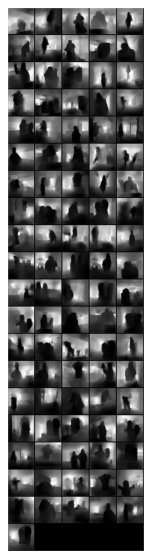

In [0]:
show(imgs, depth_mean, depth_stdev, nrow=rows)

### Initializing the model and assigning it to Cuda

In [0]:
model = ntwk.FGDepth()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)

FGDepth(
  (convA): Sequential(
    (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convB): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (convC): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convD): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (convE): Sequential(
    (0): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (blck1): DownSize(
  

### Defining Freeze class. We are using transfer learning & hence this class will be used to freeze the layers as required.

In [0]:
freezer = Freeze.Freezer()

In [0]:
for name, module in model.named_modules():
    print('name:',name)

### Defining Loss Criterion & creating scheduler

In [0]:
criterion1  = nn.BCEWithLogitsLoss()
#criterion1  = DiceLoss()
kernel_size = 3
#criterion1  = SSIM(kernel_size, reduction = 'mean')
criterion2  = SSIM(kernel_size, reduction = 'mean')

optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.9, weight_decay = 1e-5)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optim, step_size=2, gamma=0.1)

### Defining train & test loss classes

In [0]:
train_loss_fn = Train3.Training_loss1()
test_loss_fn  = Test3.Testing_loss1()

In [0]:
#train_loss_fn = Training_loss3()
#test_loss_fn  = Testing_loss3()

### Reloading model from last saved weights that are present in gdrive

In [0]:
path = f'/content/gdrive/My Drive/FG_Depth_Prediction_0531V19A.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [0]:
path_name       = '/content/gdrive/My Drive/plots_0605_V20C/'
path_model_save = f'/content/gdrive/My Drive/FG_Depth_Prediction_0605V20C.pt'

file_name  = 'train_log.txt'
log_file    = open(f'{path_name}{file_name}','w')
log_file.close()
file_name  = 'test_log.txt'
log_file   = open(f'{path_name}{file_name}','w') 
log_file.close()    

### Train & Test the model

In [0]:
train_loss_all, train_mask_loss_all, train_depth_loss_all, train_mask_iou_all, train_depth_iou_all = [], [], [], [], []
test_loss_all,  test_mask_loss_all,  test_depth_loss_all,  test_mask_iou_all,  test_depth_iou_all  = [], [], [], [], []

for epoch in range(1,5):
  train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = 0, 0, 0, 0, 0
  test_loss,  test_mask_loss,  test_depth_loss,  test_mask_iou,  test_depth_iou  = 0, 0, 0, 0, 0
  if epoch < 2:
     batch_size, loader = bs_small, train_dl_mini_1
     freezer.freeze_mask_layers(model)
  elif epoch < 3:
     batch_size, loader  = bs_small, train_dl_mini_2
     freezer.freeze_depth_layers(model)   
  elif epoch < 4:
     batch_size, loader = bs_small,  train_dl_mini_1
     freezer.freeze_mask_layers(model)
  elif epoch < 5:
     batch_size, loader  = bs_small, train_dl_mini_2
     freezer.freeze_depth_layers(model)   

  train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = train_loss_fn.train_loss_calc( \
                                                           model, model.device, loader,\
                                                           optim, epoch, criterion1, criterion2, batch_size, path_name, \
                                                           path_model_save, scheduler, model_save, img_save)
  batch_size, loader = bs_display, test_dl_display
  test_loss, test_mask_loss, test_depth_loss, test_mask_iou, test_depth_iou = test_loss_fn.test_loss_calc(             \
                                                         model, model.device, loader, optim,                           \
                                                         epoch, criterion1, criterion2, batch_size, path_name,         \
                                                         scheduler, img_save)
  scheduler.step()

  train_loss_all.append(train_loss.item()), train_mask_loss_all.append(train_mask_loss.item()), train_depth_loss_all.append(train_depth_loss.item())
  test_loss_all.append(test_loss.item()),   test_mask_loss_all.append(test_mask_loss.item()),   test_depth_loss_all.append(test_depth_loss.item())
  train_mask_iou_all.append(train_mask_iou), train_depth_iou_all.append(train_depth_iou)
  test_mask_iou_all.append(test_mask_iou),   test_depth_iou_all.append(test_depth_iou)

  gc.collect()

  0%|          | 0/834 [00:00<?, ?it/s]

Freezing Mask Layers


TR1|0|0.270|0.215|0.595|0.241:   0%|          | 0/834 [00:01<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:1 Batch_ID: 0 [0/80000 (0%)]	Loss:0.75589 Mask_Loss:0.27024 Dpth_Loss:0.21542 Mask_IOU:0.59531 Dpth_IOU: 0.24098


TR1|0|0.270|0.215|0.595|0.241:   0%|          | 1/834 [00:02<40:05,  2.89s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0605V20C.pt Epoch & Batch-ID: 1 0


TR1|500|0.273|0.107|0.591|0.622:  60%|██████    | 501/834 [08:38<06:05,  1.10s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0605V20C.pt Epoch & Batch-ID: 1 500


TR1|832|0.279|0.105|0.586|0.656: 100%|█████████▉| 832/834 [14:17<00:01,  1.03it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:1 Batch_ID: 832 [79872/80000 (100%)]	Loss:0.66260 Mask_Loss:0.27875 Dpth_Loss:0.10509 Mask_IOU:0.58574 Dpth_IOU: 0.65582


TR1|833|0.262|0.118|0.630|0.539: 100%|██████████| 834/834 [14:19<00:00,  1.03s/it]
TS1|0|-3.735|0.228|0.823|0.760:   0%|          | 0/5000 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 1 [0/40000 (0%)]	Test_Loss: -7.242751 Mask_Loss: -3.73525 Dpth_Loss: 0.22776 Mask_IOU: 0.82313 Dpth_IOU: 0.75994


TS1|1500|-3.169|0.252|0.721|0.586:  30%|██▉       | 1499/5000 [01:36<03:34, 16.30it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 1 [6000/40000 (30%)]	Test_Loss: -6.087097 Mask_Loss: -3.16940 Dpth_Loss: 0.25170 Mask_IOU: 0.72095 Dpth_IOU: 0.58593


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS1|3000|-2.925|0.208|0.711|0.770:  60%|█████▉    | 2999/5000 [03:15<02:10, 15.35it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 1 [12000/40000 (60%)]	Test_Loss: -5.642524 Mask_Loss: -2.92529 Dpth_Loss: 0.20806 Mask_IOU: 0.71115 Dpth_IOU: 0.76967


TS1|4500|-2.736|0.230|0.667|0.794:  90%|████████▉ | 4499/5000 [04:54<00:31, 15.88it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 1 [18000/40000 (90%)]	Test_Loss: -5.242137 Mask_Loss: -2.73599 Dpth_Loss: 0.22983 Mask_IOU: 0.66656 Dpth_IOU: 0.79390


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS1|4999|-2.811|0.227|0.754|0.727: 100%|█████████▉| 4999/5000 [05:27<00:00, 16.09it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 1 [19996/40000 (100%)]	Test_Loss: -5.393716 Mask_Loss: -2.81057 Dpth_Loss: 0.22743 Mask_IOU: 0.75445 Dpth_IOU: 0.72667


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS1|4999|-2.811|0.227|0.754|0.727: 100%|██████████| 5000/5000 [05:28<00:00, 15.23it/s]
  0%|          | 0/834 [00:00<?, ?it/s]

Freezing Depth Layers


TR2|0|0.271|0.107|0.602|0.613:   0%|          | 0/834 [00:01<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:2 Batch_ID: 0 [0/80000 (0%)]	Loss:0.64810 Mask_Loss:0.27068 Dpth_Loss:0.10674 Mask_IOU:0.60177 Dpth_IOU: 0.61277


TR2|0|0.271|0.107|0.602|0.613:   0%|          | 1/834 [00:02<40:53,  2.95s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0605V20C.pt Epoch & Batch-ID: 2 0


TR2|500|0.168|0.130|0.704|0.581:  60%|██████    | 501/834 [09:14<06:29,  1.17s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0605V20C.pt Epoch & Batch-ID: 2 500


TR2|832|0.144|0.127|0.737|0.573: 100%|█████████▉| 832/834 [15:24<00:02,  1.08s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:2 Batch_ID: 832 [79872/80000 (100%)]	Loss:0.41584 Mask_Loss:0.14425 Dpth_Loss:0.12733 Mask_IOU:0.73744 Dpth_IOU: 0.57296


TR2|833|0.129|0.134|0.745|0.482: 100%|██████████| 834/834 [15:26<00:00,  1.11s/it]
TS2|0|-6.542|0.278|0.796|0.578:   0%|          | 0/5000 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 2 [0/40000 (0%)]	Test_Loss: -12.806504 Mask_Loss: -6.54240 Dpth_Loss: 0.27829 Mask_IOU: 0.79578 Dpth_IOU: 0.57781


TS2|1500|-5.971|0.257|0.825|0.642:  30%|██▉       | 1499/5000 [01:35<03:47, 15.36it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 2 [6000/40000 (30%)]	Test_Loss: -11.684760 Mask_Loss: -5.97110 Dpth_Loss: 0.25745 Mask_IOU: 0.82483 Dpth_IOU: 0.64210


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS2|3000|-6.502|0.251|0.758|0.647:  60%|█████▉    | 2999/5000 [03:18<02:18, 14.46it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 2 [12000/40000 (60%)]	Test_Loss: -12.753719 Mask_Loss: -6.50224 Dpth_Loss: 0.25076 Mask_IOU: 0.75769 Dpth_IOU: 0.64727


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS2|4500|-8.339|0.243|0.872|0.676:  90%|████████▉ | 4499/5000 [05:02<00:34, 14.54it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 2 [18000/40000 (90%)]	Test_Loss: -16.435389 Mask_Loss: -8.33934 Dpth_Loss: 0.24329 Mask_IOU: 0.87228 Dpth_IOU: 0.67593


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS2|4999|-6.226|0.273|0.790|0.491: 100%|█████████▉| 4999/5000 [05:37<00:00, 14.25it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 2 [19996/40000 (100%)]	Test_Loss: -12.179285 Mask_Loss: -6.22606 Dpth_Loss: 0.27284 Mask_IOU: 0.78990 Dpth_IOU: 0.49145


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS2|4999|-6.226|0.273|0.790|0.491: 100%|██████████| 5000/5000 [05:38<00:00, 14.79it/s]
  0%|          | 0/834 [00:00<?, ?it/s]

Freezing Mask Layers


TR3|0|0.144|0.123|0.737|0.606:   0%|          | 0/834 [00:01<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:3 Batch_ID: 0 [0/80000 (0%)]	Loss:0.41140 Mask_Loss:0.14423 Dpth_Loss:0.12293 Mask_IOU:0.73742 Dpth_IOU: 0.60639


TR3|0|0.144|0.123|0.737|0.606:   0%|          | 1/834 [00:02<40:36,  2.92s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0605V20C.pt Epoch & Batch-ID: 3 0


TR3|500|0.148|0.101|0.742|0.652:  60%|██████    | 501/834 [08:40<06:09,  1.11s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0605V20C.pt Epoch & Batch-ID: 3 500


TR3|832|0.145|0.105|0.749|0.646: 100%|█████████▉| 832/834 [14:25<00:02,  1.04s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:3 Batch_ID: 832 [79872/80000 (100%)]	Loss:0.39543 Mask_Loss:0.14542 Dpth_Loss:0.10459 Mask_IOU:0.74862 Dpth_IOU: 0.64648


TR3|833|0.156|0.108|0.722|0.601: 100%|██████████| 834/834 [14:27<00:00,  1.04s/it]
TS3|0|-7.052|0.219|0.762|0.740:   0%|          | 0/5000 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 3 [0/40000 (0%)]	Test_Loss: -13.885688 Mask_Loss: -7.05230 Dpth_Loss: 0.21891 Mask_IOU: 0.76215 Dpth_IOU: 0.74005


TS3|1500|-8.039|0.214|0.786|0.727:  30%|██▉       | 1498/5000 [01:10<02:44, 21.29it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 3 [6000/40000 (30%)]	Test_Loss: -15.864146 Mask_Loss: -8.03928 Dpth_Loss: 0.21441 Mask_IOU: 0.78580 Dpth_IOU: 0.72746


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS3|3000|-9.257|0.228|0.799|0.719:  60%|█████▉    | 2998/5000 [02:21<01:32, 21.57it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 3 [12000/40000 (60%)]	Test_Loss: -18.286890 Mask_Loss: -9.25747 Dpth_Loss: 0.22805 Mask_IOU: 0.79853 Dpth_IOU: 0.71865


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS3|4500|-8.214|0.256|0.787|0.515:  90%|████████▉ | 4498/5000 [03:31<00:23, 21.41it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 3 [18000/40000 (90%)]	Test_Loss: -16.171619 Mask_Loss: -8.21374 Dpth_Loss: 0.25586 Mask_IOU: 0.78692 Dpth_IOU: 0.51506


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS3|4999|-7.175|0.241|0.801|0.630: 100%|█████████▉| 4999/5000 [03:55<00:00, 21.57it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 3 [19996/40000 (100%)]	Test_Loss: -14.108356 Mask_Loss: -7.17485 Dpth_Loss: 0.24134 Mask_IOU: 0.80136 Dpth_IOU: 0.63026


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS3|4999|-7.175|0.241|0.801|0.630: 100%|██████████| 5000/5000 [03:56<00:00, 21.16it/s]
  0%|          | 0/834 [00:00<?, ?it/s]

Freezing Depth Layers


TR4|0|0.159|0.106|0.719|0.627:   0%|          | 0/834 [00:01<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:4 Batch_ID: 0 [0/80000 (0%)]	Loss:0.42384 Mask_Loss:0.15874 Dpth_Loss:0.10635 Mask_IOU:0.71927 Dpth_IOU: 0.62712


TR4|0|0.159|0.106|0.719|0.627:   0%|          | 1/834 [00:02<40:24,  2.91s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0605V20C.pt Epoch & Batch-ID: 4 0


TR4|500|0.146|0.104|0.715|0.635:  60%|██████    | 501/834 [09:00<06:18,  1.14s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0605V20C.pt Epoch & Batch-ID: 4 500


TR4|832|0.154|0.104|0.731|0.634: 100%|█████████▉| 832/834 [14:55<00:02,  1.08s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:4 Batch_ID: 832 [79872/80000 (100%)]	Loss:0.41122 Mask_Loss:0.15368 Dpth_Loss:0.10387 Mask_IOU:0.73052 Dpth_IOU: 0.63407


TR4|833|0.181|0.104|0.692|0.653: 100%|██████████| 834/834 [14:57<00:00,  1.08s/it]
TS4|0|-9.501|0.209|0.806|0.765:   0%|          | 0/5000 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 4 [0/40000 (0%)]	Test_Loss: -18.794054 Mask_Loss: -9.50143 Dpth_Loss: 0.20881 Mask_IOU: 0.80637 Dpth_IOU: 0.76474


TS4|1500|-8.139|0.219|0.814|0.731:  30%|██▉       | 1498/5000 [01:10<02:42, 21.58it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 4 [6000/40000 (30%)]	Test_Loss: -16.057529 Mask_Loss: -8.13851 Dpth_Loss: 0.21949 Mask_IOU: 0.81374 Dpth_IOU: 0.73092


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS4|3000|-8.564|0.208|0.847|0.789:  60%|██████    | 3000/5000 [02:21<01:32, 21.57it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 4 [12000/40000 (60%)]	Test_Loss: -16.919384 Mask_Loss: -8.56375 Dpth_Loss: 0.20812 Mask_IOU: 0.84703 Dpth_IOU: 0.78924


TS4|4500|-8.233|0.220|0.816|0.765:  90%|████████▉ | 4499/5000 [03:32<00:23, 21.71it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 4 [18000/40000 (90%)]	Test_Loss: -16.246273 Mask_Loss: -8.23306 Dpth_Loss: 0.21985 Mask_IOU: 0.81590 Dpth_IOU: 0.76524


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS4|4999|-6.629|0.243|0.771|0.658: 100%|█████████▉| 4997/5000 [03:56<00:00, 21.43it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 4 [19996/40000 (100%)]	Test_Loss: -13.014671 Mask_Loss: -6.62892 Dpth_Loss: 0.24318 Mask_IOU: 0.77065 Dpth_IOU: 0.65823


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS4|4999|-6.629|0.243|0.771|0.658: 100%|██████████| 5000/5000 [03:56<00:00, 21.13it/s]


In [0]:
print('train_loss_all:',train_loss_all)
print('train_mask_loss_all:',train_mask_loss_all)
print('train_depth_loss_all:',train_depth_loss_all)
print('train_mask_iou_all:',train_mask_iou_all)
print('train_depth_iou_all:',train_depth_iou_all)
print('test_loss_all:',test_loss_all)
print('test_mask_loss_all:',test_mask_loss_all)
print('test_depth_loss_all:',test_depth_loss_all)
print('test_mask_iou_all:',test_mask_iou_all)
print('test_depth_iou_all:',test_depth_iou_all)

train_loss_all: [0.6535589694976807, 0.4582561254501343, 0.4131253957748413, 0.39150455594062805]
train_mask_loss_all: [0.2690426707267761, 0.1649726927280426, 0.15408091247081757, 0.1439601480960846]
train_depth_loss_all: [0.1154739111661911, 0.1283109486103058, 0.10496346652507782, 0.10358420759439468]
train_mask_iou_all: [0.6042672059090832, 0.6849024082361541, 0.7220494412658383, 0.7273322005734145]
train_depth_iou_all: [0.6180402486479656, 0.5816954630039802, 0.6392695248953414, 0.644802469229813]
test_loss_all: [-5.646739482879639, -13.985770225524902, -16.01897430419922, -16.32783317565918]
test_mask_loss_all: [-2.9364118576049805, -7.121550559997559, -8.120193481445312, -8.274039268493652]
test_depth_loss_all: [0.22608764469623566, 0.2573508620262146, 0.22141310572624207, 0.2202330231666565]
test_mask_iou_all: [0.7253588151939775, 0.7990142319234659, 0.8011845457585715, 0.8141669994973486]
test_depth_iou_all: [0.709030348946844, 0.6469912778947512, 0.7013605246173366, 0.7102400

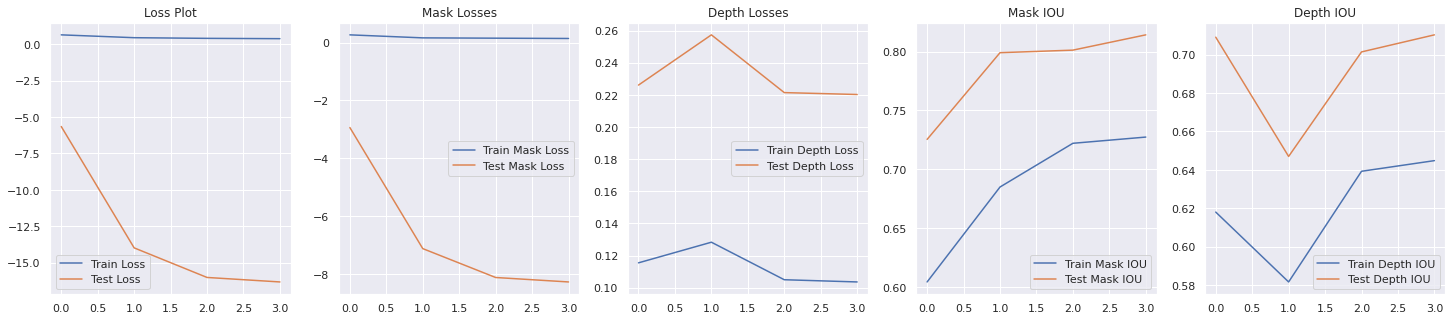

In [0]:
 
figure = plt.figure(figsize=(25,5))

plt.subplot(1,5,1)
plt.title("Loss Plot")
plt.plot(train_loss_all,label='Train Loss')
plt.plot(test_loss_all, label='Test Loss')
plt.legend(loc="best")

plt.subplot(1,5,2)
plt.title("Mask Losses")
plt.plot(train_mask_loss_all,label='Train Mask Loss')
plt.plot(test_mask_loss_all, label='Test Mask Loss')
plt.legend(loc="best")

plt.subplot(1,5,3)
plt.title("Depth Losses")
plt.plot(train_depth_loss_all,label='Train Depth Loss')
plt.plot(test_depth_loss_all, label='Test Depth Loss')
plt.legend(loc="best")

plt.subplot(1,5,4)
plt.title("Mask IOU")
plt.plot(train_mask_iou_all,label='Train Mask IOU')
plt.plot(test_mask_iou_all, label='Test Mask IOU')
plt.legend(loc="best")

plt.subplot(1,5,5)
plt.title("Depth IOU")
plt.plot(train_depth_iou_all,label='Train Depth IOU')
plt.plot(test_depth_iou_all, label='Test Depth IOU')
plt.legend(loc="best")

In [0]:
test_ds_display = md1.Make1data(f1, content_list, 390000, t400k,  
                  test_fg_bg_transforms['t_0'],test_bg_transforms['t_0'],mask_transforms['t_0'],depth_transforms['t_0'])
test_dl_display = DataLoader(test_ds_display, batch_size = 8,  shuffle = True, pin_memory = True)
batch_size, loader = 8, test_dl_display
epoch = 11
test_loss, test_mask_loss, test_depth_loss, test_mask_iou, test_depth_iou = test_loss_fn.test_loss_calc(             \
                                                         model, model.device, loader, optim,                           \
                                                         epoch, criterion1, criterion2, batch_size, path_name,         \
                                                         scheduler, img_save)